In [1]:
import torch
import torchvision
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names,create_feature_extractor
import torchvision.transforms as transforms
from sklearn import  linear_model
from sklearn.metrics import r2_score

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from utils_MNIST import fully_connected_new, make_binary
from saving_utils import load_weights

from dadapy.data import Data

In [2]:
def hm_diagonal(corr):
    nondiag_entries = corr[np.tril_indices_from(corr, k = -1)]
    return np.mean(abs(nondiag_entries))

In [3]:
dataset='pMNIST'
depth=5
W=512
k=2
learning_rate=2e-3
weight_decay=1e-3
teacher_width=8
signal_noise_ratio=3.0
n_epochs=500
square_edge=3

input_dim=10
sample_size=10000
optimizer_choice='SGD'

transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)])


'''weights=torch.load(f'./nets/{dataset}_trained_{depth}_layer_{W}_net_{k+1}_lr_{learning_rate}_wd_{weight_decay}_'
                                             f'inputdim_{input_dim}_{optimizer_choice}.pth')'''
weights=torch.load(load_weights(dataset,depth,W,k,learning_rate,weight_decay,input_dim,optimizer_choice,n_epochs,signal_noise_ratio,teacher_width,square_edge))
big_net = fully_connected_new(W, depth=depth, input_size=input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False)
big_net.load_state_dict(weights)





if dataset=='pMNIST':
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform,target_transform=make_binary())
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform,target_transform=make_binary())
    
    # Here we just convert MNIST into parity MNIST
    if input_dim !=784:
        try:
            trainset=torch.load(f'./data/MNIST_PCA_{input_dim}_train.pt')
            testset=torch.load(f'./data/MNIST_PCA_{input_dim}_test.pt')
            print("Loaded dataset")
        except IOError:
            create_pMNIST_PCA_dataset(trainset,testset,784,input_dim)
            print("Saved dataset")
            trainset=torch.load(f'./data/MNIST_PCA_{input_dim}_train.pt')
            testset=torch.load(f'./data/MNIST_PCA_{input_dim}_test.pt')
    if sample_size!=60000:
        #random_list=random.sample(range(60000), args.sample_size)
        ordered_list = list(range(0, sample_size - 1))
        trainset=torch.utils.data.Subset(trainset,ordered_list)
        
        
if dataset=='teacher':
    trainset = torch.load(f'./data/{dataset}_{input_dim}_dimension_'
                          f'teacherwidth_{teacher_width}_{signal_noise_ratio}_ratio_train_{sample_size}_samples.pt')
    testset = torch.load(f'./data/{dataset}_{input_dim}_dimension_'
                         f'teacherwidth_{teacher_width}_{signal_noise_ratio}_ratio_test_{10000}_samples.pt')     
    
    
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = big_net(images.float())
nodes,_=get_graph_node_names(big_net)

Loaded dataset


In [4]:
print(nodes)

['x', 'flatten', 'linear_body.0', 'linear_body.1', 'linear_body.2', 'linear_body.3', 'linear_body.4', 'linear_body.5', 'linear_body.6', 'linear_body.7', 'linear_out']


In [15]:
features={nodes[-2]:'out'}

In [16]:
feature_extractor=create_feature_extractor(big_net,return_nodes=features)

In [17]:
feature_extractor

fully_connected_new(
  (linear_body): Module(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU(inplace=True)
  )
  (linear_out): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = feature_extractor(images.float())

In [9]:
print(outputs)

{'out': tensor([[0.3747, 0.0000, 0.2803,  ..., 0.0023, 0.0366, 0.0000],
        [0.1613, 0.2046, 0.1494,  ..., 0.0379, 0.0644, 0.0745],
        [0.3007, 0.0000, 0.2570,  ..., 0.0000, 0.0800, 0.0000],
        ...,
        [0.0559, 0.3128, 0.1158,  ..., 0.0513, 0.0974, 0.1266],
        [0.4194, 0.0000, 0.3096,  ..., 0.0296, 0.0445, 0.0000],
        [0.0000, 0.8371, 0.0000,  ..., 0.1162, 0.1864, 0.2547]])}


In [10]:
X=outputs['out']
print(type(X))
#print(X[0])
count=0
X_check=X.numpy()
for i in range(len(X_check[0])):
    if X_check[0][i]==0:
        count+=1
print(count)

<class 'torch.Tensor'>
290


In [11]:
### fit on full layer from chunks

# chunk sizes
css = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# number of repetitions
nreps = 5

# initialised matrices of residuals and covariances
rsqs = np.zeros((len(css), nreps))
diag_covs = np.zeros((len(css), 512, nreps))
covs = np.zeros((len(css), 512, 512, nreps))

for i, cs in enumerate(css):
    print(cs)

    for r in range(nreps):
    
        indices = np.random.choice(np.arange(512), (cs), replace = False)
        Xc = X[:, indices]
        
        lm = linear_model.LinearRegression()
        lm = linear_model.Ridge(1e-8)
        
        lm.fit(Xc, X)
        X_pred = lm.predict(Xc)
        
        res = (X - X_pred)
        cov = np.cov(res.T)
        diag_covs[i, :, r] = np.diag(cov)
        
        rsqs[i, r]= r2_score(X, X_pred, multioutput = 'variance_weighted')
        covs[i,:, :, r] = cov

1
2
4
8
16
32
64
128
256
512


In [12]:
# compute regolarised correlation of residuals
reg = 1e-8
corrs = covs/(np.sqrt((diag_covs[:, :, None, :]*diag_covs[:, None, :, :]))+reg)

mean_non_diag_abs_corr = np.zeros((corrs.shape[0], corrs.shape[3]))

for i in range(corrs.shape[0]):
    for j in range(corrs.shape[3]):
        mean_non_diag_abs_corr[i, j] = hm_diagonal(corrs[i, :, :, j])

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

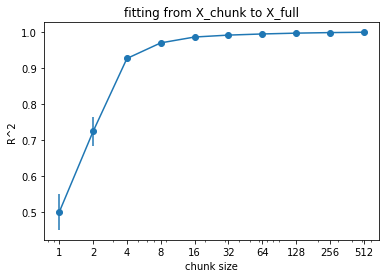

In [13]:
# plot R^2 value
plt.figure()
plt.errorbar(css, rsqs.mean(axis = 1)
             , rsqs.std(axis = 1)/np.sqrt(50), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('R^2')
plt.title('fitting from X_chunk to X_full')

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

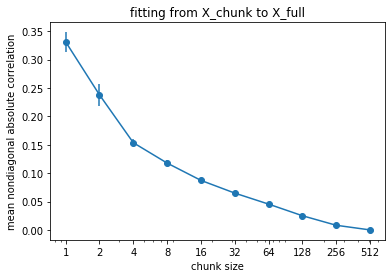

In [14]:
# plot mean nondiagonal absolute correlation
plt.figure()
plt.errorbar(css, mean_non_diag_abs_corr.mean(axis = 1)
             , mean_non_diag_abs_corr.std(axis = 1)/np.sqrt(25), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('mean nondiagonal absolute correlation')
plt.title('fitting from X_chunk to X_full')

In [273]:
data = Data(X_check)

In [274]:
data.compute_id_2NN()

(2.050542756277984, 0.0, 0.004485888685192985)

In [194]:
x=np.linspace(-1.5,1.5,1000)

def theta(x):
    out=[]
    for i in x:
        if i<0:
            out.append(0)
        else: 
            out.append(1)
    return out

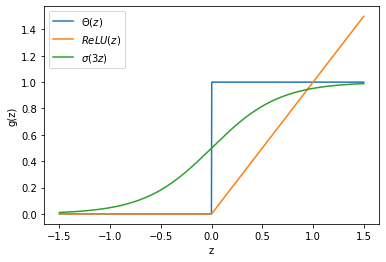

In [195]:
plt.plot(x,theta(x),label='$ \Theta (z)$')
x=torch.from_numpy(x)
plt.plot(x,torch.relu(x),label='$ReLU(z)$')
plt.plot(x,torch.sigmoid(3*x),label='$\sigma(3z)$')
#plt.title('Example of different activation functions')
plt.xlabel('z')
plt.ylabel('g(z)')
plt.legend()